In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Sklearn helpers
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss

# Plotting results
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import matplotlib
matplotlib.rcParams['font.size'] = 18

# Keras for neural networks
import keras 
import tensorflow as tf

from keras import models, layers, optimizers, losses, metrics, callbacks

Using TensorFlow backend.


In [5]:
# Plot the training history of a keras model
def plot_history(history):
    val_loss = history.history['val_loss']
    train_loss = history.history['loss']
    epochs = [int(i) for i in list(range(1, len(val_loss) + 1))]
    
    plt.figure(figsize=(8, 6))
    
    plt.plot(epochs, train_loss, 'bo-', label = 'training loss')
    plt.plot(epochs, val_loss, 'ro-', label = 'validation loss')
    plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.title('Training Curves')
    plt.legend();
    plt.show()

In [ ]:
def evaluate_model(predictions, validation_labels):
    return log_loss(validation_labels, predictions)

# Data

In [3]:
def format_data():
    train = pd.read_csv('numerai_datasets/numerai_training_data.csv')
    test = pd.read_csv('numerai_datasets/numerai_tournament_data.csv')
    
    features = [f for f in list(train) if "feature" in f]
    X = train[features]
    Y = train.target
    X_test = test[features]
    ids = test['id']
    
    X_valid = test.ix[test['data_type'] == 'validation', features]
    Y_valid = test.ix[test['data_type'] == 'validation', 'target']
    
    return X, Y, X_valid, Y_valid, X_test, ids

X, Y, X_valid, Y_valid, X_test, ids = format_data()

In [4]:
print(X.shape)
print(X_valid.shape)
print(X_test.shape)

(393613, 50)
(46362, 50)
(243393, 50)


In [9]:
X = np.array(X)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

# Model

In [6]:
model = models.Sequential()
model.add(layers.Dense(128, activation = 'elu', input_dim = X.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2048, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'elu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'elu'))

model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = losses.binary_crossentropy,
              metrics = [losses.binary_crossentropy],
              optimizer = optimizers.Adam())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              2099200   
__________

In [10]:
callback_list = [callbacks.ModelCheckpoint(filepath='models/numerai_nn_2.hdf5', 
                                           save_best_only = True, monitor = 'val_loss'),
                callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)]

history = model.fit(X, Y, epochs = 25, batch_size = 2048, 
                    validation_data = [X_valid, Y_valid], callbacks=callback_list) 

Train on 393613 samples, validate on 46362 samples
Epoch 1/25
393613/393613 [==============================] - 110s 280us/step - loss: 0.7061 - binary_crossentropy: 0.7061 - val_loss: 0.6969 - val_binary_crossentropy: 0.6969
Epoch 2/25
393613/393613 [==============================] - 56s 142us/step - loss: 0.6978 - binary_crossentropy: 0.6978 - val_loss: 0.6943 - val_binary_crossentropy: 0.6943
Epoch 3/25
393613/393613 [==============================] - 57s 144us/step - loss: 0.6973 - binary_crossentropy: 0.6973 - val_loss: 0.6934 - val_binary_crossentropy: 0.6934
Epoch 4/25
393613/393613 [==============================] - 59s 149us/step - loss: 0.6967 - binary_crossentropy: 0.6967 - val_loss: 0.6927 - val_binary_crossentropy: 0.6927
Epoch 5/25
393613/393613 [==============================] - 56s 142us/step - loss: 0.6956 - binary_crossentropy: 0.6956 - val_loss: 0.6938 - val_binary_crossentropy: 0.6938
Epoch 6/25
393613/393613 [==============================] - 56s 143us/step - loss: 

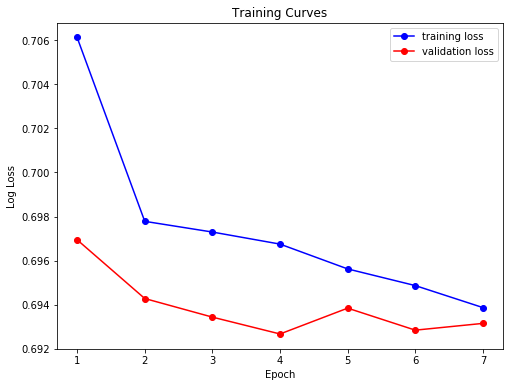

In [12]:
plot_history(history)

In [23]:
model.load_weights('models/numerai_nn_2.hdf5')
predictions = model.predict(X_test)[:, 0]

# Submissions

In [24]:
def submit(probabilities, filename):
    submission = pd.DataFrame({'id': ids, 'probability': probabilities})
    submission.to_csv('%s.csv' % filename, index = False)
    print('Submissions saved to %s.csv' % filename)

In [25]:
submit(predictions, filename = 'neural_network_2')

Submissions saved to neural_network_2.csv
